# MAT281 - Laboratorio N°11

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [1]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics_regression import *


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv(os.path.join("data","interventionscitoyendo.csv"), sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [3]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


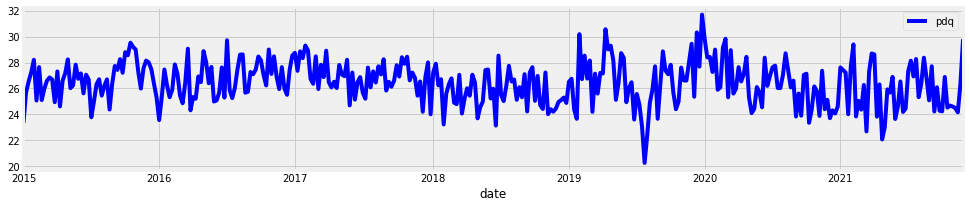

In [4]:
# graficar datos
y_s1.plot(figsize=(15, 3),color = 'blue')
plt.show()

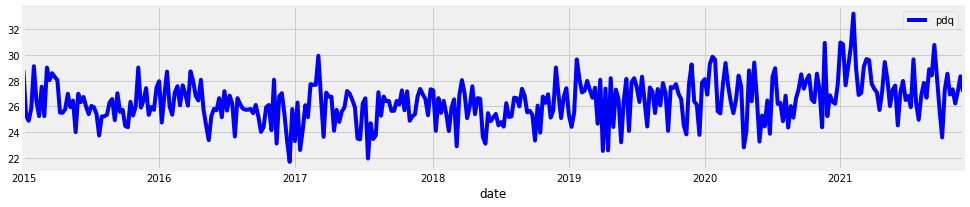

In [5]:
# graficar datos
y_s2.plot(figsize=(15, 3),color = 'blue')
plt.show()

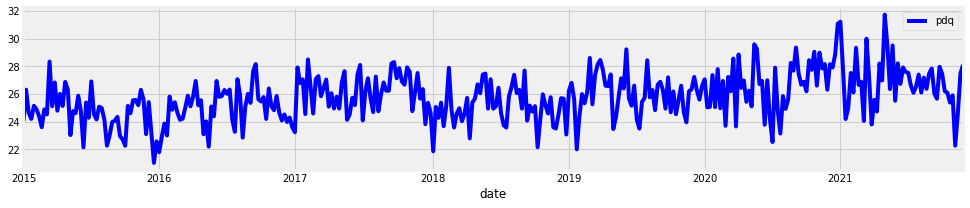

In [6]:
# graficar datos
y_s3.plot(figsize=(15, 3),color = 'blue')
plt.show()

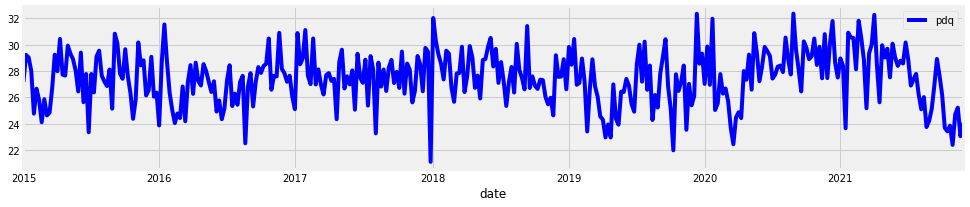

In [7]:
# graficar datos
y_s4.plot(figsize=(15, 3),color = 'blue')
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realice un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [8]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

## 1.-Análisis exploratorio

In [9]:
#descripcion de los datos:
y_s4.describe()

,pdq
count,361.000000
mean,27.460034
std,2.048360
min,21.093750
25%,26.283951
50%,27.581081
75%,28.893333
max,32.365591


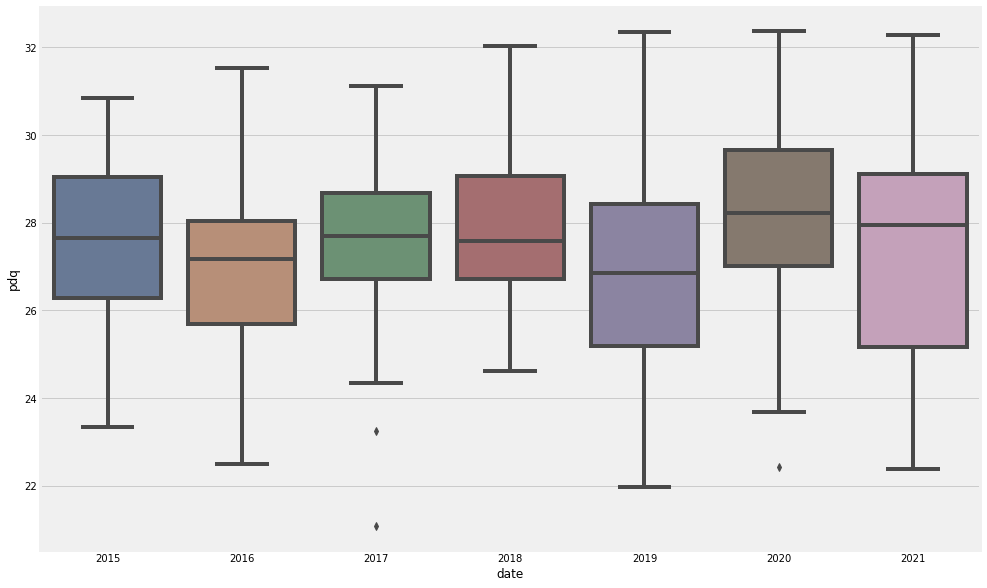

In [10]:
# boxplot
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x = y_s4.pdq.index.year,y = y_s4.pdq, ax=ax)
plt.show()

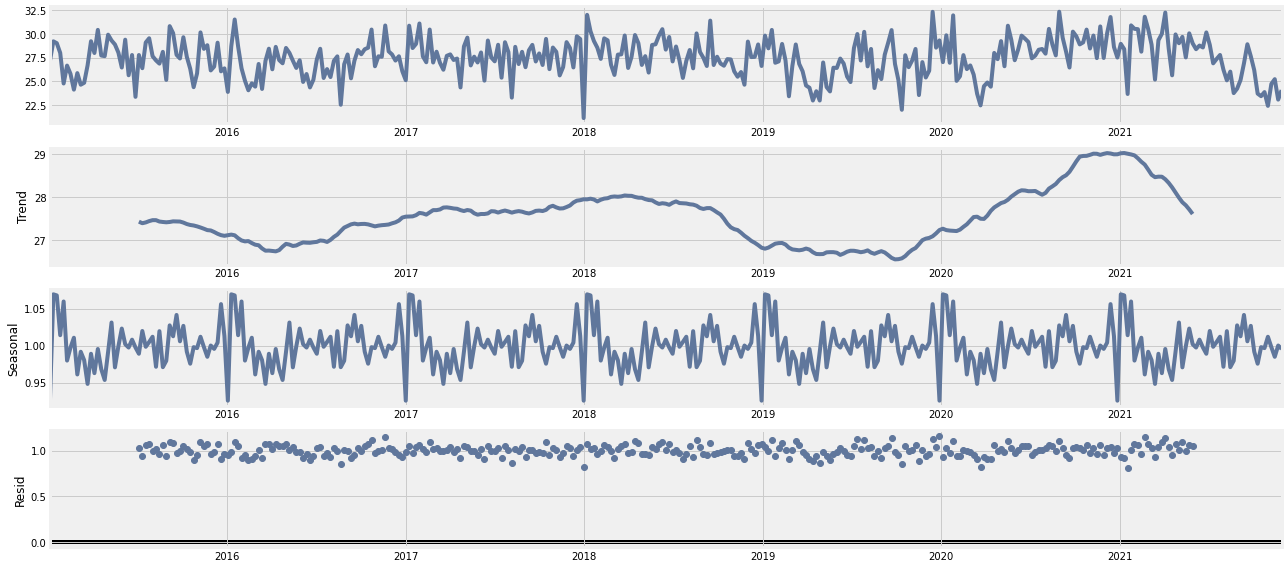

In [11]:
#descomposición serie de tiempo:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s4, model='multiplicative')
fig = decomposition.plot()
plt.show()

Analicemos cada uno de estos gráficos:
* Grafico 1: Gráfico de la serie de tiempo original.
* Grafico 2: Este gráfico nos muestra la tendencia de la serie, para este caso, no tiene una tendencia especifica pues en unos momentos la tendencia es positiva y en otros negativa.
* Grafico 3: Este gráfico nos muestra la estacionariedad de la serie, para este caso, se muestra una estacionariedad año a año, se puede observar que hay un patron que se repite.
* Grafico 4: Este gráfico nos muestra el error de la serie, para este caso, el error oscila entre 0 y 1.

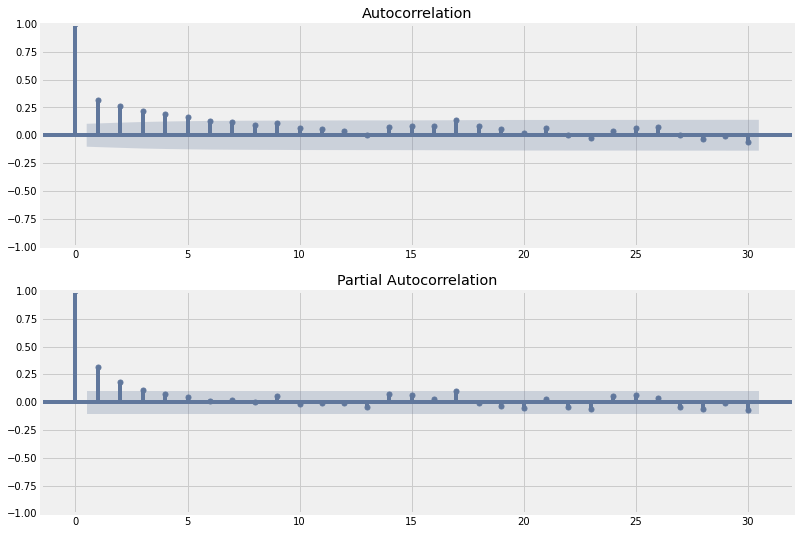

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(y_s4.pdq, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(y_s4.pdq, ax=pyplot.gca(), lags = 30)
pyplot.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

#test Dickey-Fulle:
print ('Resultados del test de Dickey-Fuller:')
pdqtest = adfuller(y_s4.pdq, autolag='AIC')
pdqoutput = pd.Series(pdqtest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(pdqoutput)

Resultados del test de Dickey-Fuller:
Test Statistic                -6.097602e+00
p-value                        1.001312e-07
#Lags Used                     3.000000e+00
Number of Observations Used    3.570000e+02
dtype: float64


Como el valor de p-value es tan pequeño se tiene que esta serie es estacionaria.

## 2.-Aplicar el modelo de pronóstico

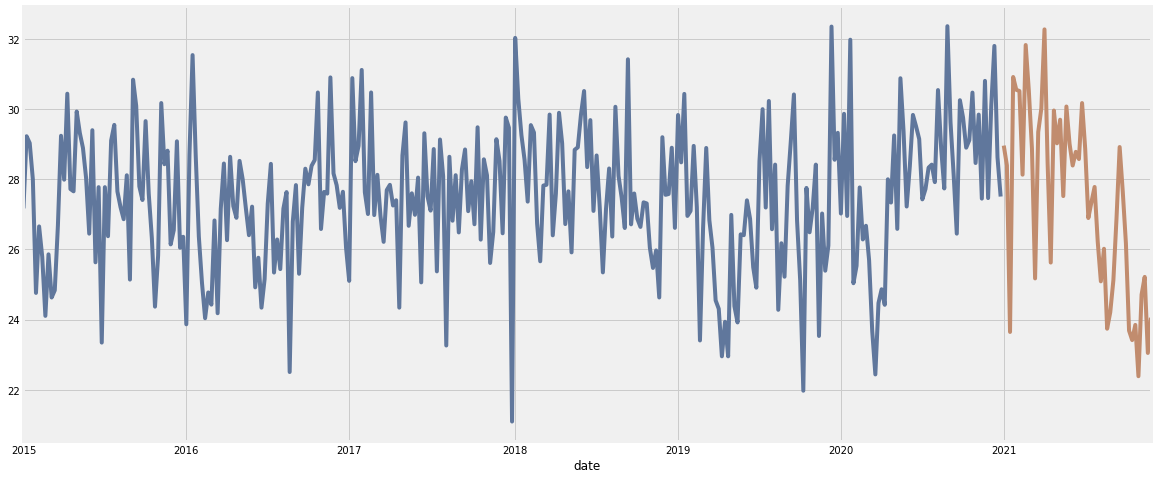

In [14]:
target_date = '2021-01-01'

# crear conjunto de entrenamiento y de testeo
mask_ds = y_s4.index < target_date

y_train = y_s4[mask_ds]
y_test = y_s4[~mask_ds]

#plotting the data
y_train['pdq'].plot()
y_test['pdq'].plot()
plt.show()

In [15]:
 # iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s4,target_date)
        frames.append(df_metrics)
    except:
        pass

In [16]:
 # juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,2.0715,6.0093,2.4514,0.0774,0.0770,0.0756,0.0746,0.0761,"SARIMA_(1,1,0)X(1,1,0,12)"
0,2.0806,5.9165,2.4324,0.0756,0.0753,0.0759,0.0729,0.0764,"SARIMA_(0,1,0)X(1,1,0,12)"
0,2.0941,6.3229,2.5145,0.0788,0.0784,0.0764,0.0759,0.0771,"SARIMA_(1,0,1)X(1,1,1,12)"
0,2.0957,6.3213,2.5142,0.0789,0.0784,0.0765,0.0760,0.0772,"SARIMA_(1,0,1)X(0,1,1,12)"
0,2.1406,6.7941,2.6066,0.0817,0.0811,0.0781,0.0786,0.0788,"SARIMA_(1,1,0)X(0,1,1,12)"
...,...,...,...,...,...,...,...,...,...
0,4.1728,21.4377,4.6301,0.1515,0.1496,0.1522,0.1461,0.1660,"SARIMA_(0,1,0)X(0,1,0,12)"
0,22.6225,576.9379,24.0195,0.8341,0.6687,0.8253,0.8042,1.6061,"SARIMA_(0,0,0)X(0,0,1,12)"
0,23.2817,585.8531,24.2044,0.8567,0.6902,0.8493,0.8260,1.6318,"SARIMA_(0,0,1)X(0,0,1,12)"
0,27.2142,748.4149,27.3572,0.9932,0.7814,0.9928,0.9579,1.9794,"SARIMA_(0,0,1)X(0,0,0,12)"


In [17]:
# ajustar mejor modelo

param = [(1,1,0),(1,1,0,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y_s4,target_date)
best_model = sarima_model.df_testig(y_s4,target_date)
best_model.head()

,y,yhat
2021-01-03,28.961039,27.881095
2021-01-10,28.396694,27.821521
2021-01-17,23.647887,28.299811
2021-01-24,30.916667,28.673600
2021-01-31,30.551724,28.488684


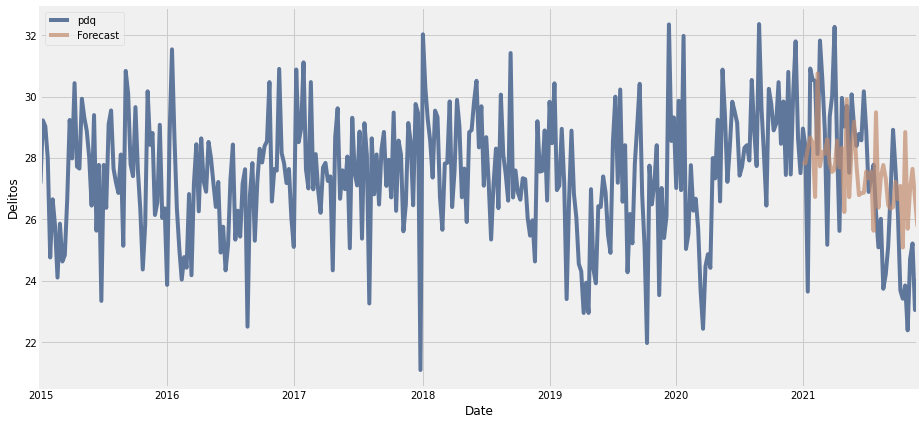

In [18]:
 # graficar mejor modelo

preds = best_model['yhat']
ax = y_s4['2015':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Delitos')
plt.legend()
plt.show()

Conclusión: Para este caso, el mejor modelo encontrado no se ajusta perfecto a los datos pero se puede considerar que se ajusta algo bien pues tiene una forma similar. Sin embargo dependiendo del criterio tambien se puede considerar que no es un modelo ideal.

## 3.-Verificar si el residuo corresponde a un ruido blanco

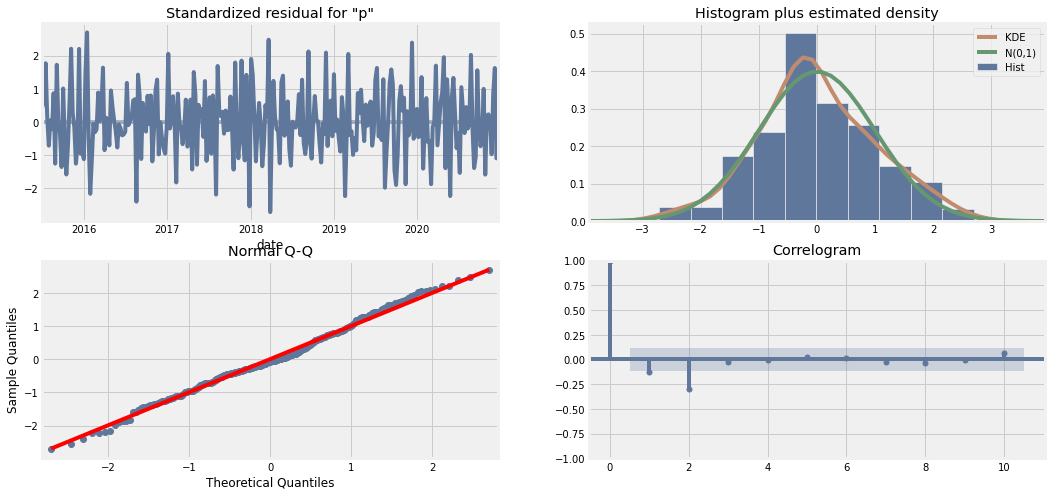

In [19]:
# resultados del error 
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

Analicemos cada uno de estos gráficos:
* gráfico 01 (standarized residual): Este gráfico nos muestra el error estandarizado en el tiempo. En este caso se observa que esta nueva serie de tiempo corresponde a una serie estacionaria que oscila entorno al cero, es decir, un ruido blanco. 
* gráfico 02 (histogram plus estimated density): Este gráfico nos muestra el histograma del error. En este caso, el histograma es muy similar al histograma de una variable N(0,1) (ruido blanco).
* gráfico 03 (normal QQ): Como el ajuste lineal cubre bastante bien los puntos se puede considerar que la distribución entre la muestra obtenida y la distribución de prueba(distribución normal) son similares.
* gráfico 04 (correlogram): Este gráfico nos muestra que no hay correlación entre ninguna de las variables, por lo que se puedan dar indicios de independencia entre las variables.

Conclusión: El residuo corresponde a un ruido blanco.